In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
from matplotlib import rcParams
import irene_utils as utils
import os
from tqdm import tqdm

In [2]:
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_bronze_folder_path = f"{srt_data_folder_path}/bronze"
srt_data_silver_folder_path = f"{srt_data_folder_path}/silver"
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
srt_data_irene_folder_path = f"{srt_data_folder_path}/irene_temp"
dataset = "nanostring_cosmx_human_nsclc"

In [3]:
# merge raw counts
adata_sample_list = []
samples = os.listdir(f'{srt_data_gold_folder_path}')
samples = [sample for sample in samples if 'batch' in sample]

for sample in samples:
    adata_sample_list.append(sc.read_h5ad(f'{srt_data_gold_folder_path}/{sample}'))
adata = ad.concat(adata_sample_list, join="inner")
adata.obs_names = adata.obs['sample'].astype(str)+'_'+adata.obs['fov'].astype(str)+'_'+adata.obs['cell_ID'].astype(str)

# qc
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# logcpm
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

annotations = pd.read_csv(f"../datasets/srt_data/irene_temp/nanostring_cosmx_human_nsclc/metadata_giotto.csv", index_col=0)

annotations = pd.read_csv(f"../datasets/srt_data/irene_temp/nanostring_cosmx_human_nsclc/metadata_giotto.csv", index_col=0)
annotations['Run_Tissue_name'] = annotations['Run_Tissue_name'].str.lower().values
annotations['cell_ID'] = annotations.cell_ID.apply(lambda x: x.split('_')[3])
annotations.index = annotations['Run_Tissue_name']+'_'+annotations['fov'].astype(str)+'_'+annotations['cell_ID'].values
transfer_columns = ['cell_type','niche','Area','AspectRatio','Width','Height','Mean.CD298','Mean.DAPI','Run_name','Dash','background']
annotations = annotations[transfer_columns]
adata = adata[adata.obs_names.isin(annotations.index)]
adata.obs[transfer_columns] = annotations.loc[adata.obs_names,transfer_columns].values
adata.obs = adata.obs.astype({'background': 'float', 'Area': 'float', 'Width': 'float', 'Height': 'float', 'Mean.CD298': 'float', 'Mean.DAPI': 'float', 'AspectRatio': 'float'})
adata.obs

# add broader cell types
adata.obs['cell_type_simplified'] = adata.obs['cell_type'].astype(str)
adata.obs.loc[adata.obs['cell_type'].apply(lambda x: 'T' in x),'cell_type_simplified'] = 'NK/T cell'
adata.obs.loc[adata.obs['cell_type'].apply(lambda x: 'tumor' in x),'cell_type_simplified'] = 'tumor'
adata.obs.loc[adata.obs['cell_type'] == 'NK','cell_type_simplified'] = 'NK/T cell'
adata.obs.loc[adata.obs['cell_type'].apply(lambda x: 'DC' in x),'cell_type_simplified'] = 'DC'
adata.obs.loc[(adata.obs['cell_type'] == 'monocyte') | (adata.obs['cell_type'] == 'macrophage') | (adata.obs['cell_type_simplified'] == 'DC'),'cell_type_simplified'] = 'myeloid'

/Users/irene.bonafonte/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/9k/rsnwv_zs49n5zryyfc4myl9d6b36ql/T/ipykernel_26720/3658355458.py:27: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[transfer_columns] = annotations.loc[adata.obs_names,transfer_columns].values


(91691, 960)


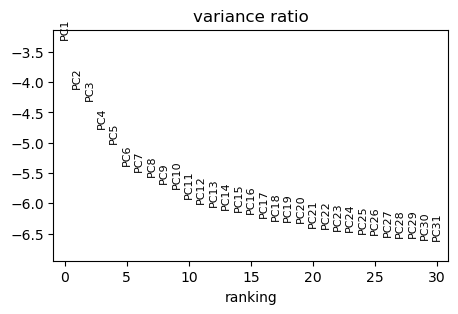

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/irene.bonafonte/miniforge3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/irene.bonafonte/miniforge3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/irene.bonafonte/miniforge3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


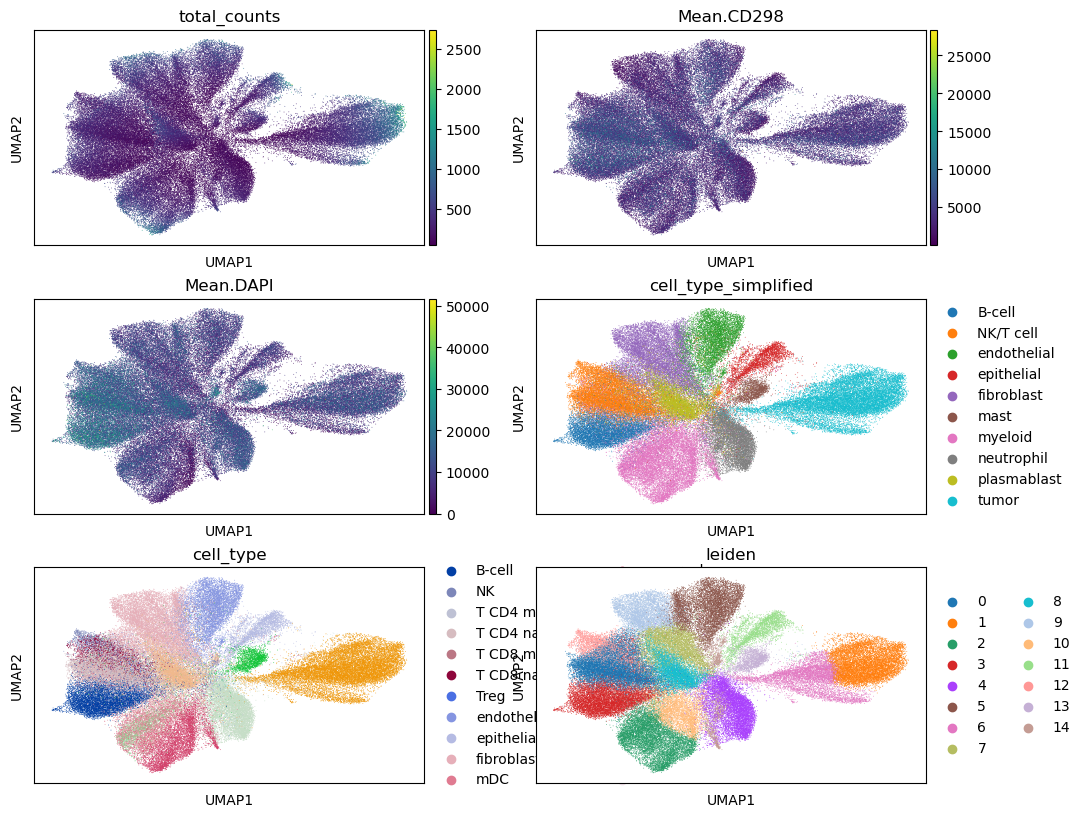

In [4]:
adata_lung5_r3 = utils.preprocess_subsample(adata, ['lung5_rep3'], n_neighbours=30, n_pcs=30, plot_covariates=['total_counts','Mean.CD298','Mean.DAPI','cell_type_simplified','cell_type'])

In [5]:
ncols = 5
fovs = adata_lung5_r3.obs.fov.unique()
genes = adata_lung5_r3.var_names
mean_ratio = np.zeros((len(genes), len(fovs))) + 1000
var_ratio = np.zeros((len(genes), len(fovs))) + 1000

prop_fov = 0.2
j = 0
fov = fovs[j]

if (fov-1)%ncols == 0:
    neighbours = [1, -ncols, ncols]
elif fov%ncols == 0:
    neighbours = [-1, -ncols, ncols]
elif fov in [x+1 for x in range(ncols)]:
    neighbours = [-1, 1, ncols]
elif fov in [x+1 for x in range(max(fovs)-ncols, max(fovs))]:
    neighbours = [-1, 1, -ncols]
else:
    neighbours = [-1, 1, -ncols, ncols]
    
relative_n = neighbours[0]

n = fov + relative_n

if abs(relative_n) == 1:
    axis = 0 # move along x coordinate
elif abs(relative_n) == ncols: 
    axis = 1 # move along y coordiante   
direction = np.sign(relative_n)

min_coor, max_coor = min(adata_lung5_r3.obsm['spatial'][adata_lung5_r3.obs.fov == fov,axis]), max(adata_lung5_r3.obsm['spatial'][adata_lung5_r3.obs.fov == fov,axis])
border = direction * max(direction*min_coor, direction*max_coor)

lim1, lim2 = border, border - direction * (max_coor - min_coor) * prop_fov
fov_cells = (adata_lung5_r3.obs.fov == fov) & (adata_lung5_r3.obsm['spatial'][:,axis] >= min(lim1, lim2)) & (adata_lung5_r3.obsm['spatial'][:,axis] <= max(lim1, lim2))

lim1, lim2 = border + direction * (max_coor - min_coor) * prop_fov, border - direction * (max_coor - min_coor) * prop_fov
fn_cells = (adata_lung5_r3.obs.fov.isin([fov, n])) & (adata_lung5_r3.obsm['spatial'][:,axis] >= min(lim1, lim2)) & (adata_lung5_r3.obsm['spatial'][:,axis] <= max(lim1, lim2))


In [26]:
np.minimum(mean_ratio[:,j], ratio).shape

(960,)

In [30]:
fov_mean = adata_lung5_r3[fov_cells,].X.var(axis=0)
fn_mean = adata_lung5_r3[fn_cells,].X.var(axis=0)
ratio = fov_mean/fn_mean
mean_ratio = np.minimum(mean_ratio[:,j], ratio)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [35]:
fov_mean = adata_lung5_r3[fov_cells,].X.var(axis=0)
fn_mean = adata_lung5_r3[fn_cells,].X.var(axis=0)
ratio = fov_mean/fn_mean
ratio.shape, mean_ratio[:,j].shape

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
adata_lung5_r3[fov_cells & (adata_lung5_r3.raw.X.todense() != 0),:].X.var(axis=0)

In [ ]:
ncols = 5
fovs = adata_lung5_r3.obs.fov.unique()
genes = adata_lung5_r3.var_names
mean_ratio = np.zeros((len(genes), len(fovs))) + 1000
var_ratio = np.zeros((len(genes), len(fovs))) + 1000

prop_fov = 0.2

for j, fov in tqdm(enumerate(fovs)):
    
    # define neighbour fovs
    if (fov-1)%ncols == 0:
        neighbours = [1, -ncols, ncols]
    elif fov%ncols == 0:
        neighbours = [-1, -ncols, ncols]
    elif fov in [x+1 for x in range(ncols)]:
        neighbours = [-1, 1, ncols]
    elif fov in [x+1 for x in range(max(fovs)-ncols, max(fovs))]:
        neighbours = [-1, 1, -ncols]
    else:
        neighbours = [-1, 1, -ncols, ncols]
            
    for relative_n in neighbours:
        n = fov + relative_n
        
        # define cells
        if abs(relative_n) == 1:
            axis = 0 # move along x coordinate
        elif abs(relative_n) == ncols: 
            axis = 1 # move along y coordiante   
        direction = np.sign(relative_n)

        min_coor, max_coor = min(adata_lung5_r3.obsm['spatial'][adata_lung5_r3.obs.fov == fov,axis]), max(adata_lung5_r3.obsm['spatial'][adata_lung5_r3.obs.fov == fov,axis])
        border = direction * max(direction*min_coor, direction*max_coor)

        lim1, lim2 = border, border - direction * (max_coor - min_coor) * prop_fov
        fov_cells = (adata_lung5_r3.obs.fov == fov) & (adata_lung5_r3.obsm['spatial'][:,axis] >= min(lim1, lim2)) & (adata_lung5_r3.obsm['spatial'][:,axis] <= max(lim1, lim2))

        lim1, lim2 = border + direction * (max_coor - min_coor) * prop_fov, border - direction * (max_coor - min_coor) * prop_fov
        fn_cells = (adata_lung5_r3.obs.fov.isin([fov, n])) & (adata_lung5_r3.obsm['spatial'][:,axis] >= min(lim1, lim2)) & (adata_lung5_r3.obsm['spatial'][:,axis] <= max(lim1, lim2))
        
        # compute mean
        mean_ratio[:,j] = np.minimum(mean_ratio[:,j], adata_lung5_r3[fov_cells,].X.mean(axis=0)/adata_lung5_r3[fn_cells,].X.mean(axis=0))
        variance_ratio[:,j] = np.minimum(variance_ratio[:,j], adata_lung5_r3[fov_cells,].X.var(axis=0)/adata_lung5_r3[fn_cells,].X.var(axis=0))
            
mean_ratio = pd.DataFrame(mean_ratio, index=genes, columns=fovs)
max_mean, mean_mean = mean_ratio.max(axis=1).values, mean_ratio.mean(axis=1).values
mean_ratio['max'], mean_ratio['mean'] = max_mean, mean_mean
mean_ratio.sort_values(by='max', ascending=False)

variance_ratio = pd.DataFrame(variance_ratio, index=genes, columns=fovs)
max_var, mean_var = variance_ratio.max(axis=1).values, variance_ratio.mean(axis=1).values
variance_ratio['max'], variance_ratio['mean'] = max_var, mean_var
variance_ratio.sort_values(by='max', ascending=False)